In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
from os.path import join
from shapely.geometry import Polygon
from matplotlib import pyplot
%matplotlib inline

In [2]:
os.chdir('Data/')
os.getcwd()

'C:\\Users\\karan\\Python Notebooks\\MPI\\Data'

In [23]:
all_shp = gpd.read_file('puma.geojson')
all_shp['PUMACE10'] = all_shp['PUMACE10'].astype(int)
all_shp = all_shp[['STATEFP10','PUMACE10','NAMELSAD10','geometry']]
all_shp.head()

,STATEFP10,PUMACE10,NAMELSAD10,geometry
0,36,3803,NYC-Manhattan Community District 10--Central H...,"POLYGON ((-73.95150599999999 40.812008, -73.95..."
1,36,3707,NYC-Bronx Community District 5--Morris Heights...,"POLYGON ((-73.90980999999999 40.857348, -73.90..."
2,36,3201,Nassau County (Northwest)--North Hempstead Tow...,"POLYGON ((-73.628102 40.816038, -73.627775 40...."
3,36,3301,Suffolk County (Northwest)--Huntington Town (N...,"POLYGON ((-73.36815199999999 40.863641, -73.36..."
4,36,3303,Suffolk County (Northwest)--Smithtown Town PUMA,"POLYGON ((-73.232677 40.913281, -73.151922 40...."


In [4]:
df = pd.read_csv('sf_puma.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,origin_puma,dest_puma,od_counts
0,101,101,17413
1,101,102,4828
2,101,103,3755
3,101,104,149
4,101,105,421


In [5]:
all_shp[all_shp['PUMACE10']==101]

,STATEFP10,PUMACE10,NAMELSAD10,geometry
191,34,101,Atlantic County (East)--Atlantic City & Ventno...,"POLYGON ((-74.508858 39.309347, -74.51181 39.3..."
386,06,101,Alameda County (North)--Berkeley & Albany Citi...,"POLYGON ((-122.245314 37.869774, -122.245313 3..."


In [6]:
all_shp.shape

(571, 4)

In [20]:
all_shp['STATEFP10'].unique()

array(['36', '34', '17', '06'], dtype=object)

In [27]:
def convert_to_poly(geom):
    if(geom.type=='Polygon'):
        return geom
    else:
        return geom[0]
    
all_shp['geometry'] = all_shp['geometry'].map(convert_to_poly)

In [34]:
file_dict = {'ny':'nyc_puma.csv','la':'la_puma.csv','sf':'sf_puma.csv','chic':'chic_puma.csv'}
city_list = ['ny','la','sf','chic']
#state_dict = {'ny':['34','36'],'la':['06'],'sf':['06'],'chic':['17']}
state_dict = {'ny':['36'],'la':['06'],'sf':['06'],'chic':['17']}
bin_dict = {
    'ny':[    0,   5000,   10000,  25000,  50000,  100000, 723000],
    'la':[    0,   5000,   10000,  25000,  50000,  100000, 533000],
    'sf':[    0,   5000,   10000,  25000,  50000,  100000, 294000],
    'chic':[    0,   5000,   10000,  25000,  50000,  100000, 249000]
    }
df_list = []
colors = ['darkred','red','orange','yellow','lime','green']
colormap = {i: colors[i] for i in range(6)}

def map_puma_id(puma,city):
    try:
        shp_match = all_shp[(all_shp['PUMACE10']==puma)&(all_shp['STATEFP10'].isin(state_dict[city]))]
        puma_id = list(shp_match['PUMACE10'])[0]
        state_id = list(shp_match['STATEFP10'])[0]
        return str(state_id) + '_' + str(puma_id)
    except IndexError:
        return '0'

for city in city_list:
    df = pd.read_csv(file_dict[city])
    bins = bin_dict[city]
    labels = np.arange(1,len(bins))
    
    df['binned'] = pd.cut(df['od_counts'], bins=bins, labels=labels)
    df['color'] = df['binned'].map(lambda x: colormap[5-(x-1)])    
    df.drop(columns=['Unnamed: 0','binned'],inplace=True)  
    
    df['origin_puma'] = df['origin_puma'].map(lambda x: map_puma_id(int(x),city)) 
    df['dest_puma'] = df['dest_puma'].map(lambda x: map_puma_id(int(x),city))
    df = df[(df['origin_puma']!='0')&(df['dest_puma']!='0')]
    
    df_list.append(df)
    df.to_csv('d3_puma_'+city+'.csv')
    
    shp = all_shp[all_shp['STATEFP10'].isin(state_dict[city])]
    shp['puma_id'] = shp.apply(lambda row: str(row['STATEFP10'])+'_'+str(row['PUMACE10']),axis=1)
    shp = shp[shp['puma_id'].isin(list(df['origin_puma'].unique())+list(df['dest_puma'].unique()))]
    shp.drop(columns=['STATEFP10','PUMACE10'],inplace=True)
    shp.to_file('d3_puma_'+city+'.geojson',driver='GeoJSON')

c:\users\karan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


722318


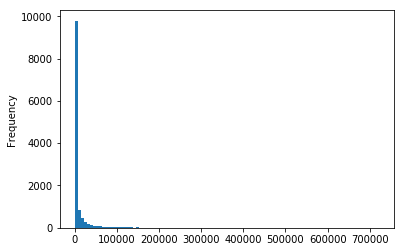

In [55]:
df_list[0].od_counts.plot(kind='hist',bins=100)
print(df_list[0]['od_counts'].max())

532918


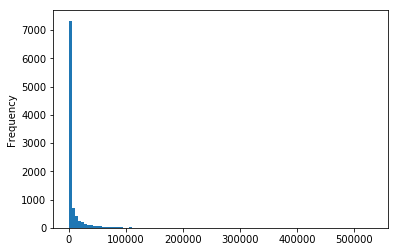

In [56]:
df_list[1].od_counts.plot(kind='hist',bins=100)
print(df_list[1]['od_counts'].max())

293001


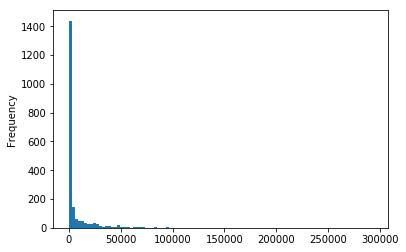

In [59]:
df_list[2].od_counts.plot(kind='hist',bins=100)
print(df_list[2]['od_counts'].max())

248292


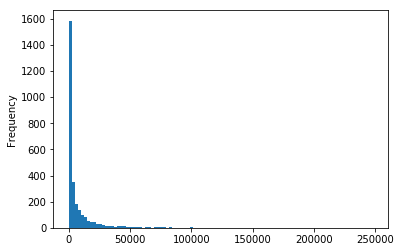

In [60]:
df_list[3].od_counts.plot(kind='hist',bins=100)
print(df_list[3]['od_counts'].max())